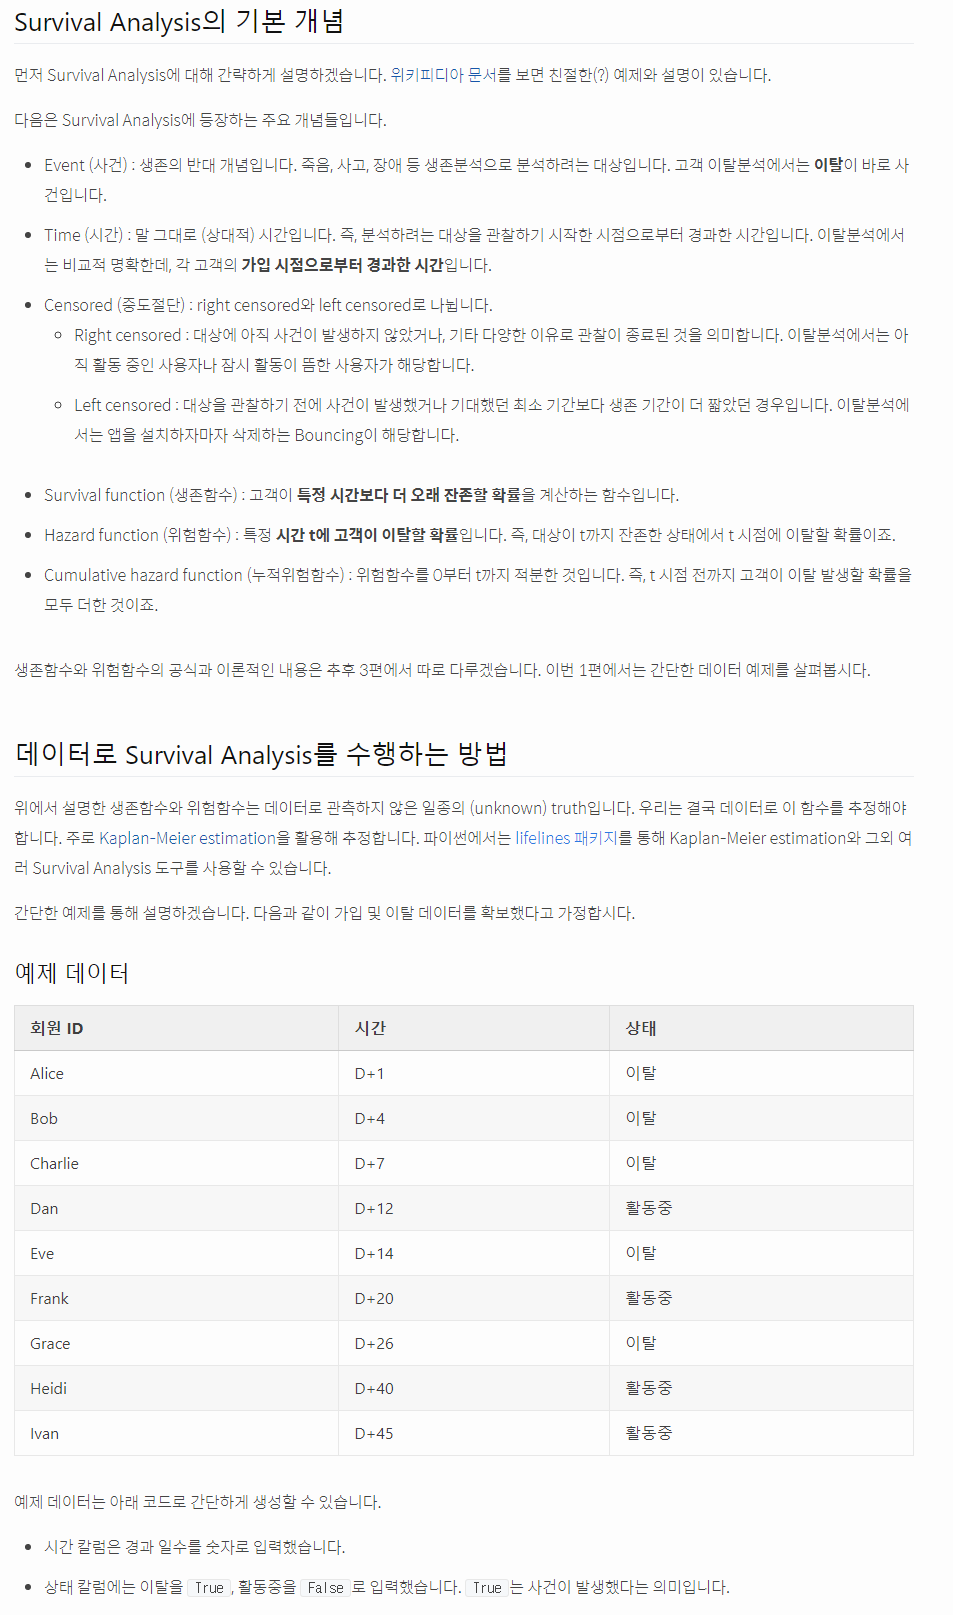

In [7]:
!pip install lifelines
import pandas as pd
data = pd.DataFrame(
    {
        'time': [1, 4, 7, 12, 14, 20, 26, 40, 45],
        'event': [True, True, True, False, True, False, True, False, False]
    },
    index = ['Alice', 'Bob', 'Charlie', 'Dan', 'Eve', 'Frank', 'Grace', 'Heidi', 'Ivan']
)

## **Survival function 추정**
먼저 생존함수를 추정해 봅시다. 다음 코드로 간단하게 할 수 있습니다.

<AxesSubplot:xlabel='time (days)', ylabel='survival function, $\\hat{S}(t)$'>

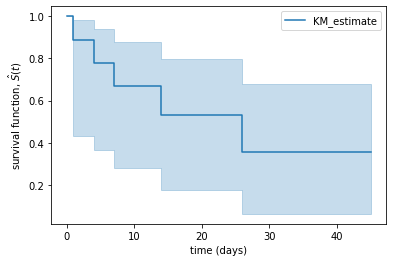

In [4]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(data["time"], data["event"])

plot = kmf.plot_survival_function()
plot.set_xlabel('time (days)')
plot.set_ylabel('survival function, $\hat{S}(t)$')
plot

- 파란선은 생존함숫값입니다. 시간이 지날수록 이탈자가 발생하며 낮아지는 것을 볼 수 있습니다. 
- 하늘색 영역은 신뢰구간입니다. KaplanMeierFitter에 alpha 값을 지정해 조절할 수 있습니다. 기본값은 0.05 (95%)입니다.

## **Cumulative hazard function 추정**
이번에는 누적위험함수를 추정해 봅시다. Nelson-Aalen estimator로 추정할 수 있습니다.

<AxesSubplot:xlabel='time (days)', ylabel='cumulative hazard function, $\\hat{Λ}(t)$'>

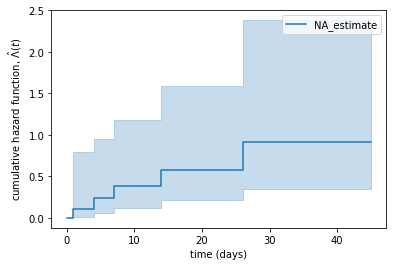

In [5]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(data["time"], data["event"])

plot = naf.plot_cumulative_hazard()
plot.set_xlabel('time (days)')
plot.set_ylabel('cumulative hazard function, $\hat{Λ}(t)$')
plot

- 누적위험함수는 생존함수와 반대로 시간이 갈수록 증가합니다. 물론 시간이 갈수록 이탈위험이 늘어나는 것은 아닙니다. 이탈자가 누적되기 때문입니다.

lifeline 패키지는 이 밖에도 다양한 estimator를 제공합니다. 자세한 내용은 공식 문서를 참고하세요.
https://lifelines.readthedocs.io/en/latest/

## **이탈방지 평가**
우리가 서비스 이탈에 관심을 가지는 이유는 결국 이탈을 방지해야 하기 때문이겠죠. 서비스에 신규 가입한 고객에게 특별한 프로모션을 진행했다고 가정해 봅시다. 다음과 같이 A/B 테스트 결과를 얻었습니다. (편의상 똑같은 데이터를 두 번 사용합시다)

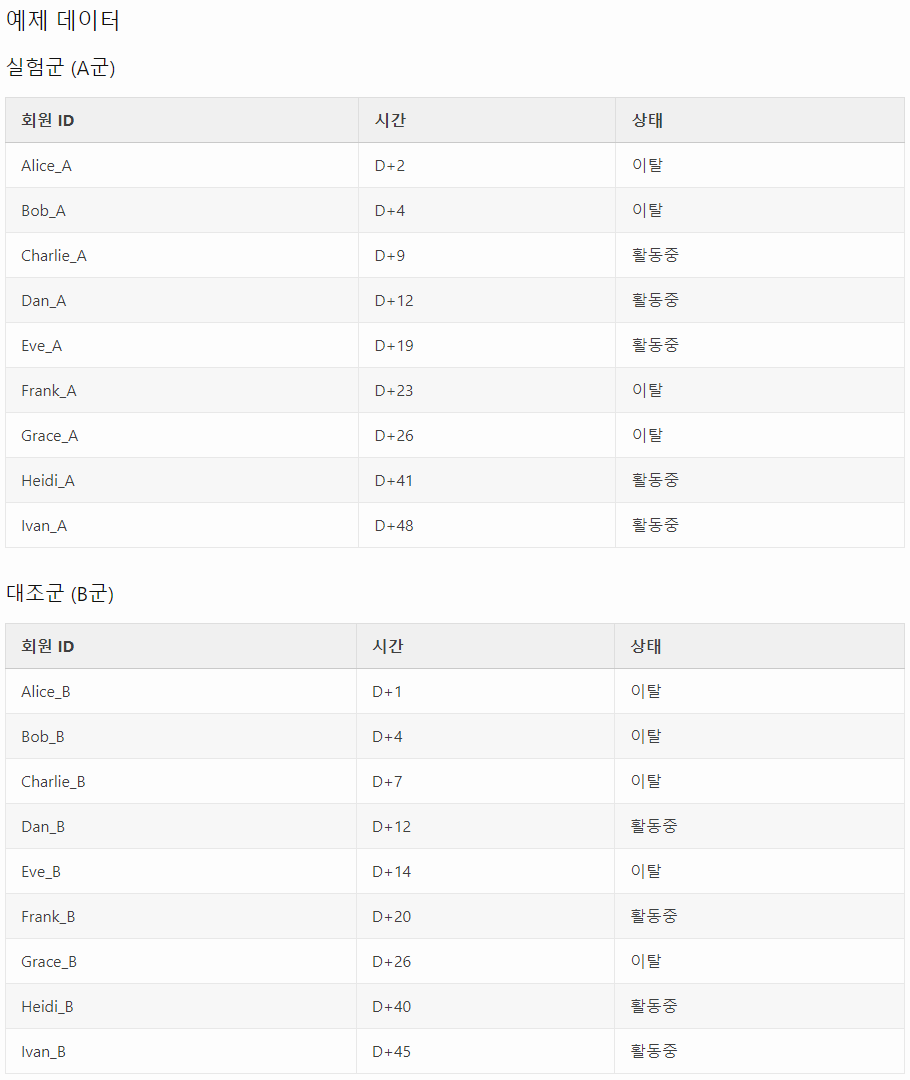

In [6]:
data_A = pd.DataFrame(
    {
        'time': [2, 4, 9, 12, 19, 23, 26, 41, 48],
        'event': [True, True, False, False, False, True, True, False, False]
    },
    index = ['Alice_A', 'Bob_A', 'Charlie_A', 'Dan_A', 
             'Eve_A', 'Frank_A', 'Grace_A', 'Heidi_A', 'Ivan_A']
)

data_B = pd.DataFrame(
    {
        'time': [1, 4, 7, 12, 14, 20, 26, 40, 45],
        'event': [True, True, True, False, True, False, True, False, False]
    },
    index = ['Alice_B', 'Bob_B', 'Charlie_B', 'Dan_B', 
             'Eve_B', 'Frank_B', 'Grace_B', 'Heidi_B', 'Ivan_B']
)

## **효과 분석**
두 그룹의 생존함수와 누적위험함수를 각각 추정해 봅시다.

<AxesSubplot:xlabel='time (days)', ylabel='survival function, $\\hat{S}(t)$'>

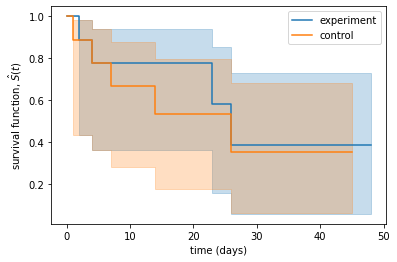

In [8]:
kmf = KaplanMeierFitter()
kmf.fit(data_A["time"], data_A["event"], label="experiment")
ax_kmf = kmf.plot()
kmf.fit(data_B["time"], data_B["event"], label="control")
ax_kmf = kmf.plot(ax=ax_kmf)

ax_kmf.set_xlabel('time (days)')
ax_kmf.set_ylabel('survival function, $\hat{S}(t)$')
ax_kmf



육안으로 봤을 땐 실험군 대상으로 진행한 프로모션이 효과가 있는듯 보입니다. 생존함숫값이 상승했고, 위험함숫값이 감소했죠. 하지만 95% 신뢰구간이 상당히 겹치므로 프로모션이 정말 고객이탈을 유의미하게 줄였는지 알아봐야 합니다. 생존분석에서는 Logrank test를 사용해 유의성을 검증합니다.

<AxesSubplot:xlabel='time (days)', ylabel='cumulative hazard function, $\\hat{Λ}(t)$'>

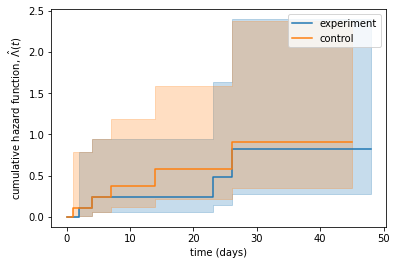

In [9]:
naf = NelsonAalenFitter()
naf.fit(data_A["time"], data_A["event"], label="experiment")
ax_naf = naf.plot()
naf.fit(data_B["time"], data_B["event"], label="control")
ax_naf = naf.plot(ax=ax_naf)

ax_naf.set_xlabel('time (days)')
ax_naf.set_ylabel('cumulative hazard function, $\hat{Λ}(t)$')
ax_naf

## **유의성 검증**
Logrank test는 생존함수 분포를 비교하고 유의한 차이가 있는지 알아보는 가설 검정 기법입니다. Mantel-Cox test라고도 합니다. 파이썬에서는 다음과 같이 Logrank test를 실행할 수 있습니다.

In [10]:
from lifelines.statistics import logrank_test
logrank_test(data_A["time"], data_B["time"], data_A["event"], data_B["event"]).p_value

0.6791912509835747

앞서 얻은 A/B 테스트 결과를 Logrank test로 검증해 보면 p-value가 0.6792로 계산됩니다.

즉, 프로모션은 유의한 성과를 얻지 못했습니다.

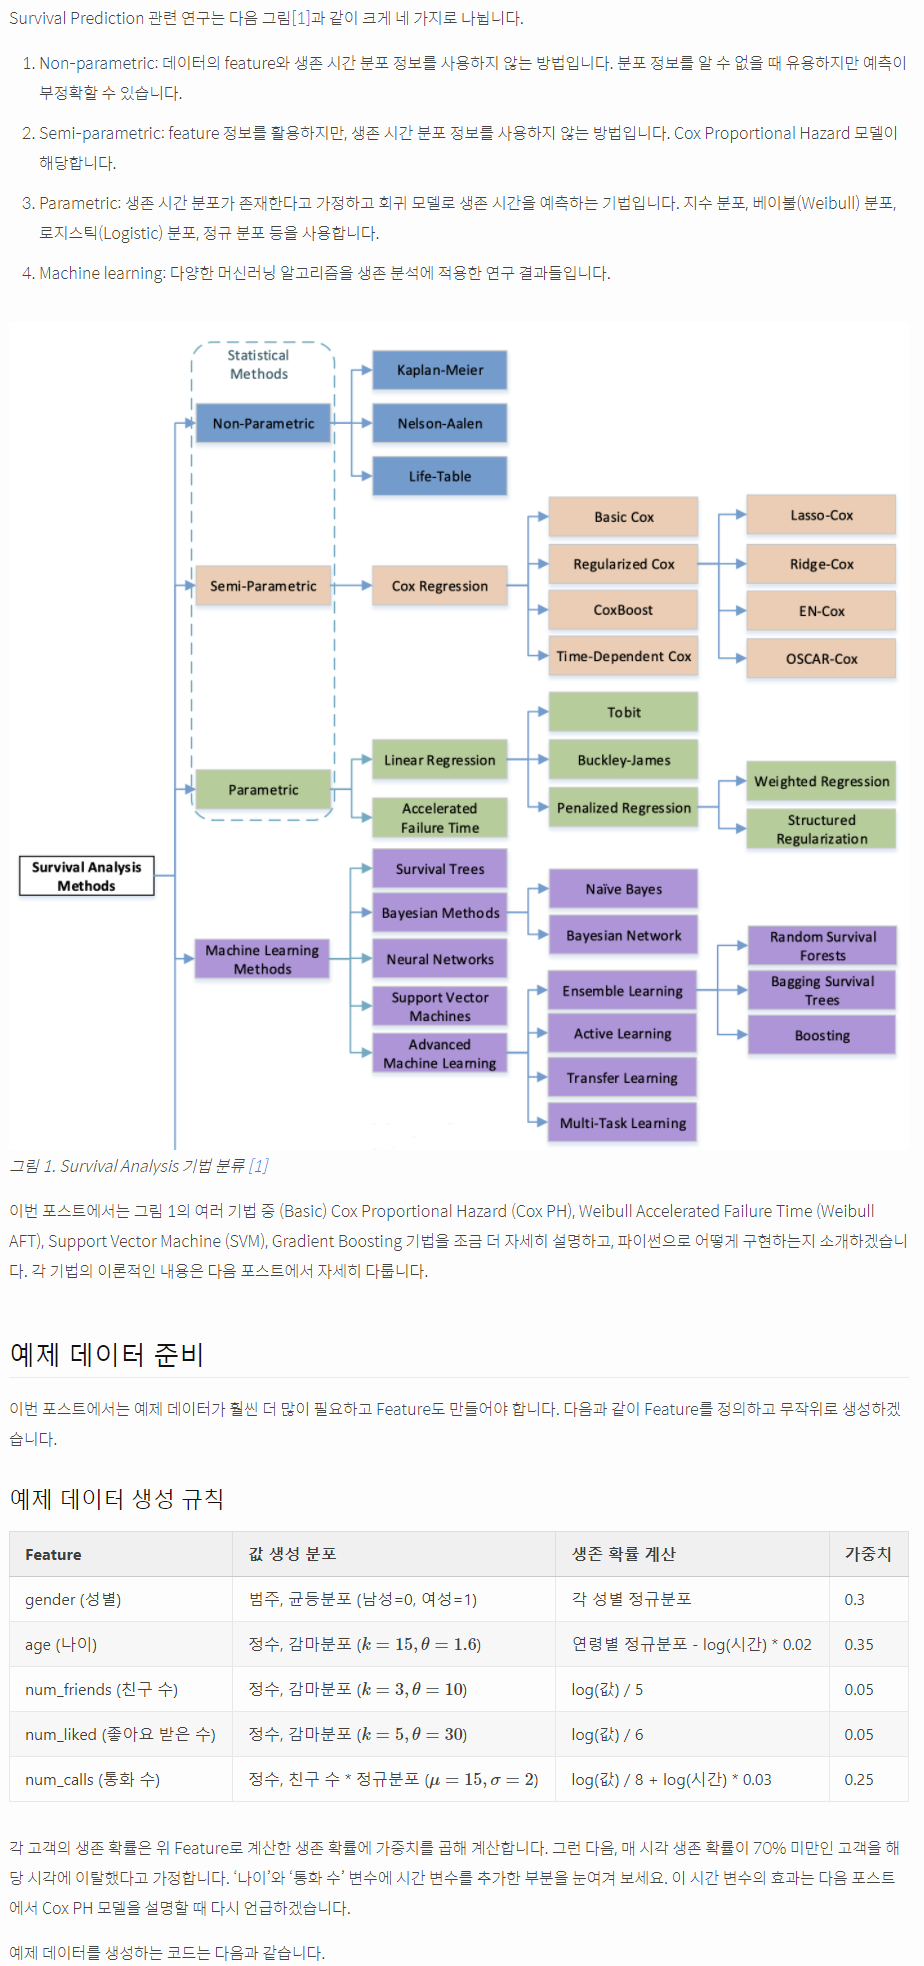

In [4]:
import numpy as np
import pandas as pd

def generate_features(num_samples):
    genders = np.random.randint(0, 2, num_samples)
    ages = np.random.gamma(15, 1.6, num_samples).round()
    nums_friends = np.random.gamma(3, 10, num_samples).round()
    nums_liked = np.random.gamma(5, 30, num_samples).round()
    nums_calls = np.multiply(nums_friends, np.random.normal(15, 2, num_samples).clip(1)).round()
    
    return pd.DataFrame({
        'gender': genders,
        'age': ages,
        'num_friends': nums_friends,
        'num_liked': nums_liked,
        'num_calls': nums_calls
    })

def get_normal_prob(mean, stdev):
    return np.clip(np.random.normal(mean, stdev), 0.1, 0.99)

def get_death_prob(t, features):
    zipped = pd.DataFrame({
        'gender': features['gender'].apply(
            lambda x:
                get_normal_prob(0.9, 0.01) if x == 0
                else get_normal_prob(0.85, 0.01)
        ),
        'age' : features['age'].apply(
            lambda x: ((0 <= x < 10 and get_normal_prob(0.7, 0.02)) or
                       (10 <= x < 20 and get_normal_prob(0.85, 0.03)) or
                       (20 <= x < 30 and get_normal_prob(0.9, 0.05)) or
                       (30 <= x < 40 and get_normal_prob(0.75, 0.05)) or
                       (40 <= x < 50 and get_normal_prob(0.7, 0.05)) or            
                       get_normal_prob(0.2, 0.05)) - np.random.normal(0.02 * np.log(t), 0.005)
        ),
        'num_friends': features['num_friends'].apply(
            lambda x: np.clip(np.log(max(1, x)) * 0.2, 0.1, 0.99)
        ),
        'num_liked': features['num_liked'].apply(
            lambda x: np.clip(np.log(max(1, x)) * (1/6), 0.1, 0.99)
        ),
        'num_calls': features['num_calls'].apply(
            lambda x: np.clip(np.log(max(1, x)) * (1/8) + np.random.normal(0.03 * np.log(t), 0.005), 0.1, 0.99)
        )
    })
    
    return zipped['gender']*0.3+zipped['age']*0.35+zipped['num_friends']*0.05
            +zipped['num_liked']*0.05+zipped['num_calls']*0.25
            #실제에선 줄바꿈 없이 코딩
    
def generate_dataset(num_samples, death_threshold, max_time):
    data = generate_features(num_samples)
    data['event'] = False
    data['time'] = 1
    time = 1
    
    while time < max_time:
        time = time + 1
        prob = get_death_prob(time, data)
        data['time'] = data['time'] + ~(data['event'] | (prob < death_threshold)) * 1
        data['event'] = data['event'] | (prob < death_threshold)

    return data

이제 무작위로 3,000명을 생성하고 매일 생존 확률을 계산해 확률이 75% 미만인 고객을 이탈시킵니다. 500일까지 생존한 고객은 이탈하지 않았다고 간주합니다. survival function을 그려보면 500일 동안 대략 25%가 점차 이탈하는 것을 볼 수 있습니다.

<AxesSubplot:xlabel='time (day)', ylabel='survival function, $\\hat{S}(t)$'>

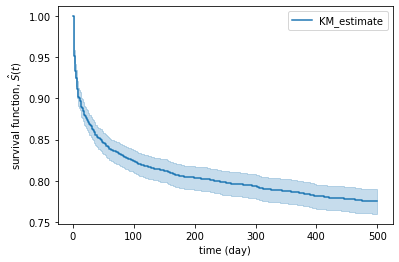

In [12]:
from lifelines import KaplanMeierFitter

data = generate_dataset(3000, 0.75, 500)

kmf = KaplanMeierFitter()
kmf.fit(data["time"], data["event"])

plot = kmf.plot_survival_function()
plot.set_xlabel('time (day)')
plot.set_ylabel('survival function, $\hat{S}(t)$')
plot

데이터 준비를 마쳤습니다. 이제 이 데이터로 여러 예측 모델을 만들어 보겠습니다.

## **Semi-parametric methods**

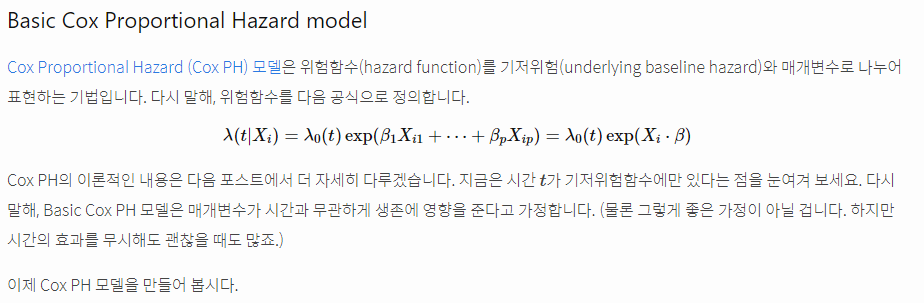

Iteration 1: norm_delta = 1.56247, step_size = 0.9000, log_lik = -5322.05003, newton_decrement = 742.77235, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.72032, step_size = 0.9000, log_lik = -4554.96211, newton_decrement = 126.22211, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.46383, step_size = 0.9000, log_lik = -4414.17372, newton_decrement = 18.77715, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.11193, step_size = 1.0000, log_lik = -4393.85533, newton_decrement = 0.36512, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00336, step_size = 1.0000, log_lik = -4393.48495, newton_decrement = 0.00018, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -4393.48477, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 3000 total observations, 2325 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3000
number of events observed = 675
   partial log-likelihood = -4393.48
         time fit was run = 2021-12-08 13:22:20 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
gender        0.77       2.15       0.08             0.61             0.92                 1.84                 2.51
age           0.23       1.26       0.01             0.22             0.25                 1.25                 1.28
num_friends  -0.05       0.95       0.01            -0.07            -0.02                 0.93                 0.98
num_liked    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
num_calls    -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00

                z      p   -log2(p)
covariate                          
gender       9.73 <0.005      71.98
age         34.14 <0.005     845.97
num_friends -3.31 <0.005      10.07
num_liked   -4.29 <0.005      15.74
num_calls   -5.88 <0.005      27.84
---
Concordance = 0.90
Partial AIC = 8796.97
log-likelihood ratio test = 1857.13 on 5 df
-log2(p) of ll-ratio test = inf

C-index(cross-validation) =  -1.1064263000398882


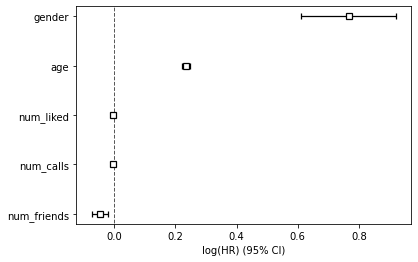

In [13]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

cox = CoxPHFitter()

#fitting
cox.fit(data, duration_col='time', event_col='event', show_progress=True)
cox.print_summary()
cox.plot()

#cross-validation
cox_cv_result = k_fold_cross_validation(cox, data, duration_col='time', 
                                        event_col='event', k=5)
print('C-index(cross-validation) = ', np.mean(cox_cv_result))

데이터를 무작위로 생성했기 때문에 결과는 조금씩 달라지겠지만, 교차 검증 결과는 대략 0.86 ~ 0.90정도 입니다. 
정확도는 Concordance Index(C-index)로 계산하며 0~1 사이의 값이고 높을수록 좋습니다. C-index 계산 방법과 그외 다른 정확도 지표 또한 다음 포스트에서 자세히 설명하겠습니다.

데이터가 나름 깔끔해서 그런지 예측 정확도가 높게 나왔습니다. 하지만 모델의 가설이 단순하기 때문에 최상의 결과라고 보기 어렵겠죠. 머신러닝 모델은 훨씬 더 좋은 결과를 낼 수 있습니다.

결과 해석법
1. 각 항목의 p-value 확인 → 0.05보다 작으면 유의한 결과
2. exp(coef) = HR(위험비)이며 1보다 크면 위험 증가, 1보다 작으면 위험 감소
3. exp(coef) = 2.15면 사망위험 115% 높다

## **Parametric methods**

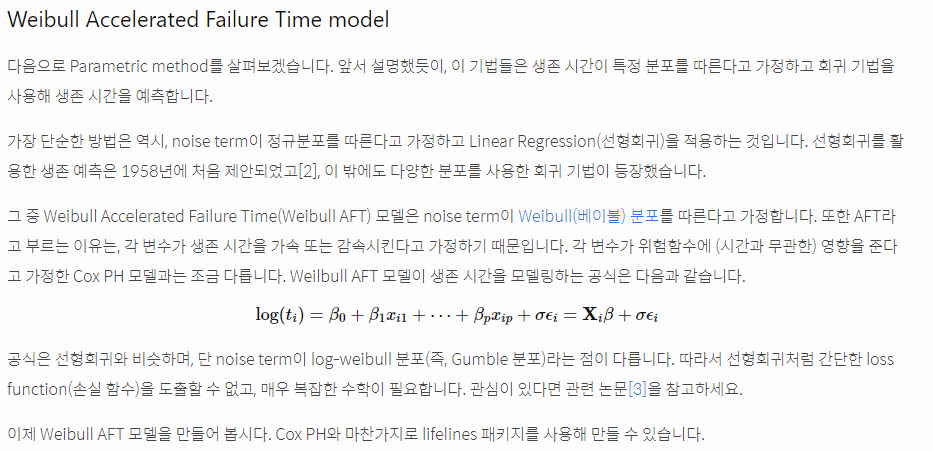

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3413655370429156
            Iterations: 45
            Function evaluations: 46
            Gradient evaluations: 45
     fun: 1.3413655370429156
     jac: array([ 5.64512010e-07,  1.66465858e-07,  1.98890629e-07,  1.87182018e-07,
        1.53290520e-07,  9.80688299e-08, -3.74845582e-07])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 45
    njev: 45
  status: 0
 success: True
       x: array([-2.80840182, -0.71665573,  2.63708225,  1.50270333,  0.28820335,
       14.95316059, -0.6552441 ])


<lifelines.WeibullAFTFitter: fitted with 3000 total observations, 2325 right-censored observations>
             duration col = 'time'
                event col = 'event'
   number of observations = 3000
number of events observed = 675
           log-likelihood = -4024.10
         time fit was run = 2021-12-08 13:22:21 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                           
lambda_ age          -0.46       0.63       0.01            -0.48            -0.43                 0.62                 0.65
        gender       -1.43       0.24       0.15            -1.74            -1.13                 0.18                 0.32
        num_calls     0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
        num_friends   0.09       1.09       0.03             0.04             0.14                 1.04                 1.15
        num_liked     0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
        Intercept    14.95   3.12e+06       0.43            14.12            15.79             1.35e+06             7.19e+06
rho_    Intercept    -0.66       0.52       0.03            -0.72            -0.59                 0.49                 0.55

                         z      p   -log2(p)
param   covariate                           
lambda_ age         -34.69 <0.005     873.63
        gender       -9.33 <0.005      66.36
        num_calls     5.60 <0.005      25.49
        num_friends   3.31 <0.005      10.06
        num_liked     3.76 <0.005      12.52
        Intercept    35.10 <0.005     894.01
rho_    Intercept   -20.72 <0.005     314.40
---
Concordance = 0.90
AIC = 8062.19
log-likelihood ratio test = 1905.17 on 5 df
-log2(p) of ll-ratio test = inf

C-index(cross-validation) =  -1.3448829508368687


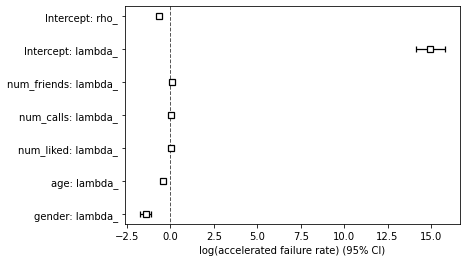

In [14]:
from lifelines import WeibullAFTFitter
from lifelines.utils import k_fold_cross_validation

#fitting
aft = WeibullAFTFitter()
aft.fit(data, duration_col='time', event_col='event', show_progress=True)
aft.print_summary()
aft.plot()

#cross-validation
aft_cv_result = k_fold_cross_validation(aft, data, duration_col='time', 
                                        event_col='event', k=5)
print('C-index(cross-validation) = ', np.mean(aft_cv_result))


Cox PH와 비슷하게, 0.87~0.90의 정확도가 나올 겁니다. 이제 머신러닝 모델로 넘어갑시다.

## **Machine Learning methods**

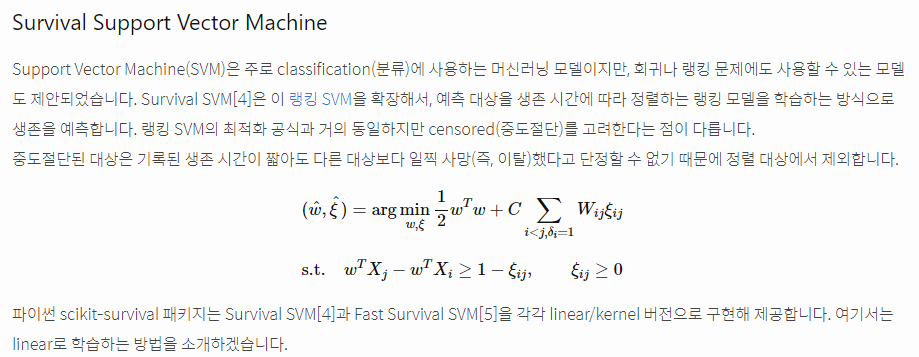

In [5]:
!pip install scikit-survival

from sksurv.svm import NaiveSurvivalSVM, FastSurvivalSVM
from sklearn.model_selection import GridSearchCV, KFold

X = data.drop(data.columns[-2:], axis=1)
y = data.apply(lambda x: (x.event, x.time), axis=1).to_numpy(dtype=[('event', 'bool'), ('time', 'float64')])

print(X)

#SVM
svm = NaiveSurvivalSVM()
svm_params = {'alpha': np.arange(0.2, 1.5, 0.1)}
svm_gcv = GridSearchCV(svm, svm_params, cv=KFold(n_splits=5))
svm_result = svm_gcv.fit(X, y)
print('C-index = {}, (parameters: {})'.format(svm_result.best_score_, svm_result.best_params_))

#Fast SVM
fsvm = FastSurvivalSVM()
fsvm_params = {'alpha': np.arange(0.2, 1.5, 0.1), 'rank_ratio': np.arange(0, 1.1, 0.1)}
fsvm_gcv = GridSearchCV(fsvm, fsvm_params, cv=KFold(n_splits=5))
fsvm_result = fsvm_gcv.fit(X, y)
print('C-index = {}, (parameters: {})'.format(fsvm_result.best_score_, fsvm_result.best_params_))

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\anjui\anaconda3\python.exe' 'C:\Users\anjui\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' build_wheel 'C:\Users\anjui\AppData\Local\Temp\tmp10dg6ksw'
       cwd: C:\Users\anjui\AppData\Local\Temp\pip-install-y6kcxqhw\scikit-survival_3f712efee4f74c31a9eb71a9a1e5808a
  Complete output (461 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating build\lib.win-amd64-3.9\sksurv
  copying sksurv\base.py -> build\lib.win-amd64-3.9\sksurv
  copying sksurv\column.py -> build\lib.win-amd64-3.9\sksurv
  copying sksurv\compare.py -> build\lib.win-amd64-3.9\sksurv
  copying sksurv\exceptions.py -> build\lib.win-amd64-3.9\sksurv
  copying sksurv\functions.py -> build\lib.win-amd64-3.9\sksurv
  copying sksurv\metrics.py -> build\lib.win-amd64-3.9\sksurv
  copying sksurv\nonparametric.py -> build\lib.win-amd64-3.9\sksurv
  copying sk

  Using cached scikit-survival-0.16.0.tar.gz (2.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached scikit_learn-0.24.2-cp39-cp39-win_amd64.whl (6.9 MB)
  Using cached ecos-2.0.7.post1.tar.gz (126 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numexpr-2.8.0-cp39-cp39-win_amd64.whl (88 kB)
  Using cached osqp-0.6.2.post0-cp39-cp39-win_amd64.whl (162 kB)
  Using cached qdldl-0.1.5.post0-cp39-cp39-win_amd64.whl (74 kB)
  Running setup.py clean for ecos
Failed to build scikit-survival ecos


ModuleNotFoundError: No module named 'sksurv'

## **Gradient Boosting**
scikit-survival 패키지는 Survival Gradient Boosted Regression도 제공합니다. Cox PH 모델이 사용하는 partial likelihood loss를 기본 손실함수로 사용해 각 대상의 이탈(즉, 사망) 위험도를 예측합니다. 그 외 다른 손실함수(예: squared)를 지정하면 생존 시간을 예측합니다.

Cox PH를 사용해 만들어 봅시다. 아무 설정을 하지 않았지만, 0.96에 가까운 훨씬 더 좋은 정확도를 얻을 수 있습니다.

In [6]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gbr = GradientBoostingSurvivalAnalysis()
gbr_gcv = GridSearchCV(gbr, {}, cv=KFold(n_splits=5))
gbr_result = gbr_gcv.fit(X, y)
print('C-index = ', gbr_result.best_score_)

ModuleNotFoundError: No module named 'sksurv'

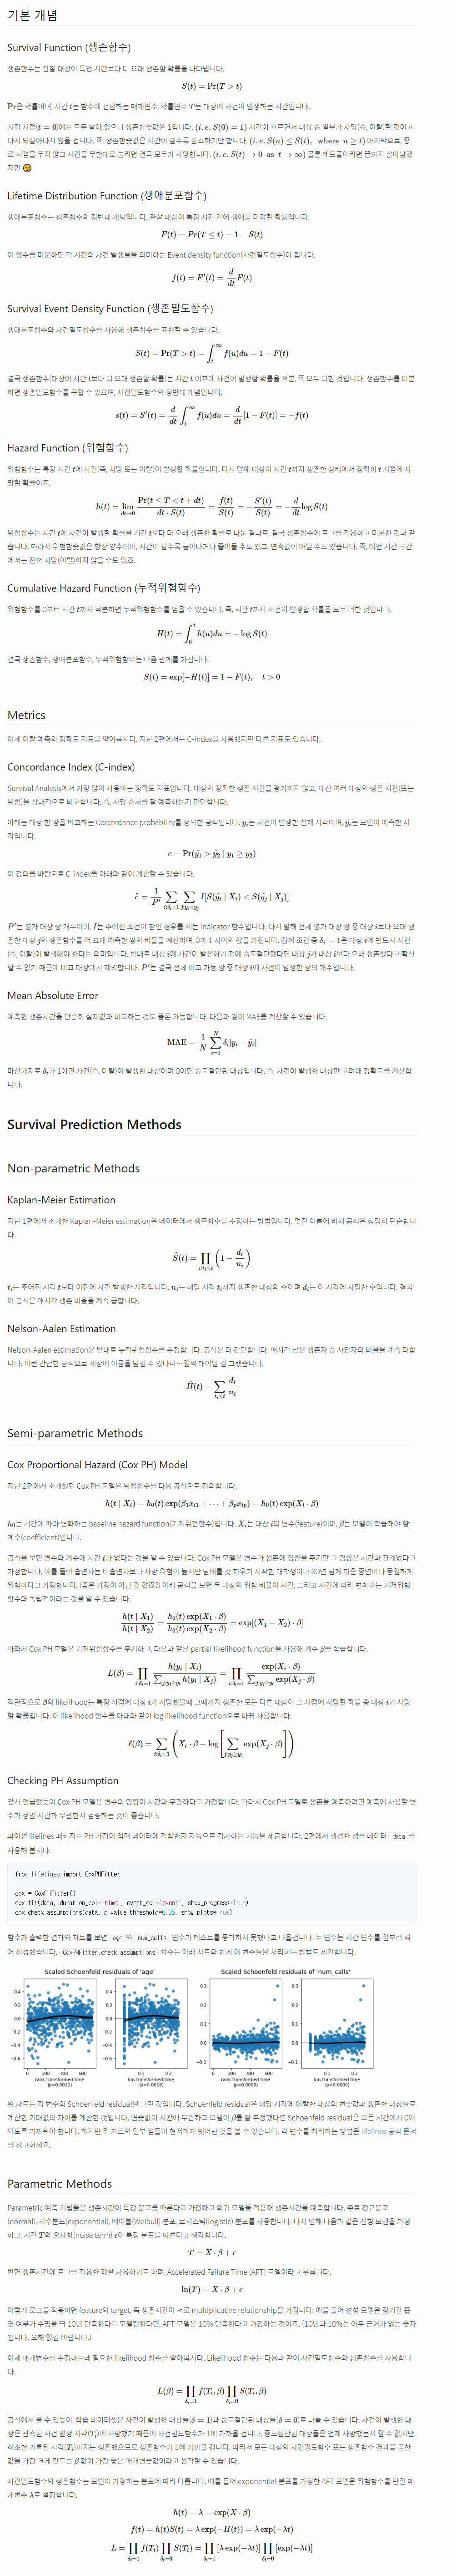

출처 

1. https://hyperconnect.github.io/2019/07/16/survival-analysis-part1.html